In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib import cm
import pandas as pd
from tqdm import tqdm
import functions as f
from pathlib import Path

In [2]:
beta = np.deg2rad(-50)
i    = np.deg2rad(30)
to_Myr = 9.78462

In [3]:
t = 20
X, Y, VX, VY, RHO = np.load(f'./../simulation/simulation/output_npy/data_{t}.npy')
FIG_DIR = Path('./../figures/')

In [4]:
VX, VY = f.add_solid_body_rotation(X, Y, VX, VY, 0.4)
X, Y, VX, VY = f.rotate_bar(beta, X, Y, VX, VY)
X, Y, VR = f.incline_galaxy(i, X, Y, VX, VY)

Text(0.5, 1.0, '$V_{radial}$')

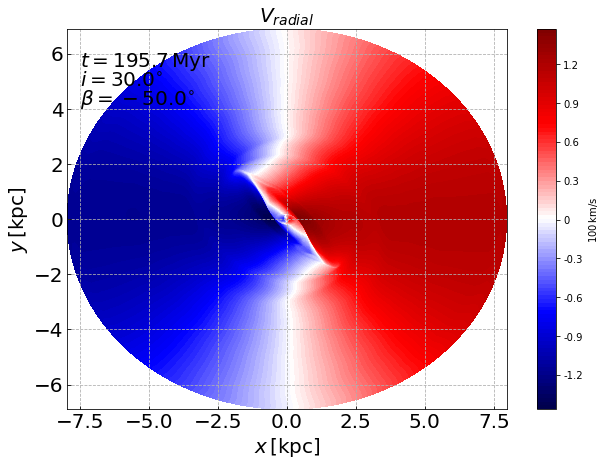

In [5]:
fig, ax = plt.subplots(figsize=(11, 7), sharex=True, sharey=True)
levels = np.linspace(VR.min(), VR.max(), 101)
cbarticks = np.linspace(VR.min().round(1), VR.max().round(1), 11)
norm = mc.BoundaryNorm(levels, 256)
im1 = ax.contourf(X, Y, VR, norm=norm, levels=levels, cmap='seismic')
ax.annotate(r'$t=%.1f\, \rm Myr$' % (t * to_Myr),
            xy=(0.03, 0.90), xycoords='axes fraction', fontsize=20, color='k')
ax.annotate(r'$i=%.1f ^{\circ}$' % (np.rad2deg(i)),
            xy=(0.03, 0.85), xycoords='axes fraction', fontsize=20, color='k')
ax.annotate(r'$\beta=%.1f ^{\circ}$' % (np.rad2deg(beta)),
            xy=(0.03, 0.80), xycoords='axes fraction', fontsize=20, color='k')
# ax.axhline(0.3, c='black')
# ax.axhline(-0.3, c='black')

plt.colorbar(im1,ticks=cbarticks, format='%g', label=r'$\rm 100\, km/s$')

ax.grid(ls='dashed')
ax.tick_params(labelsize=20, direction='in')
ax.set_xlabel(r'$x\, \rm [kpc]$', fontsize=20)
ax.set_ylabel(r'$y\, \rm [kpc]$', fontsize=20)
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_aspect('1')
ax.set_title(r'$V_{radial}$', fontsize=20)

### pixelation

In [6]:
step = 0.1

VR_array          = f.mean_in_pixel(X, Y, step, VR)
RHO_array         = f.mean_in_pixel(X, Y, step, RHO)
VR_weighted_array = f.mean_in_pixel(X, Y, step, VR * RHO)
x_weighted_array  = f.mean_in_pixel(X, Y, step, X * RHO)

x_center_array, y_center_array = f.centers_of_pixel(X, Y, step)

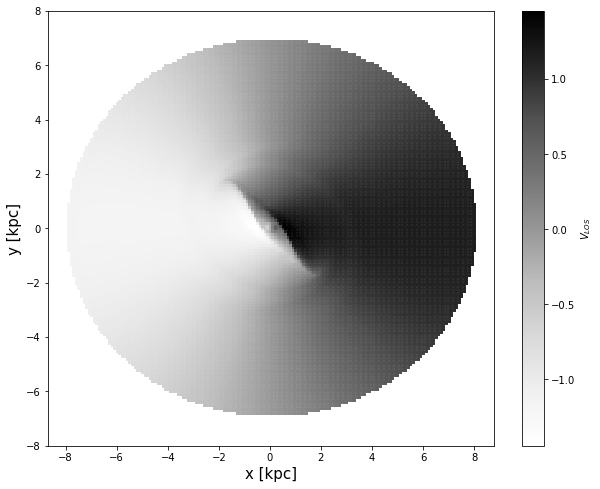

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

levels = np.linspace(np.nanmin(VR_array), np.nanmax(VR_array), 101)
norm = mc.BoundaryNorm(levels, 256)

sc = ax.scatter(x_center_array, y_center_array, c=VR_array, 
                cmap='Greys', marker='s', s=4)
ax.set_xlabel('x [kpc]', fontsize=15)
ax.set_ylabel('y [kpc]', fontsize=15)
ax.set_ylim(-8, 8)
plt.colorbar(sc, label=r'$V_{LOS}$')

In [9]:
VR_array = f.make_symmetric(x_center_array, VR_array)
RHO_array = f.make_symmetric(x_center_array, RHO_array)
VR_weighted_array = f.make_symmetric(x_center_array, VR_weighted_array)
x_weighted_array = f.make_symmetric(x_center_array, x_weighted_array)

### integrating

In [10]:
TW_method = pd.DataFrame(data={'y':np.unique(y_center_array)})

In [11]:
TW_method.dropna(how='any', inplace=True)

In [12]:
import time
start = time.time()

vr_average = []
x_average = []
for y in TW_method['y']:
    mask = (y_center_array == y)
    vr_average.append(np.nansum(VR_weighted_array[mask]) / np.nansum(RHO_array[mask]))
    x_average.append(np.nansum(x_weighted_array[mask])   / np.nansum(RHO_array[mask]))
    
end = time.time()
print(end - start)

0.032956838607788086


<ipython-input-12-2c0832e14a6b>:8: RuntimeWarning: invalid value encountered in double_scalars
  vr_average.append(np.nansum(VR_weighted_array[mask]) / np.nansum(RHO_array[mask]))
<ipython-input-12-2c0832e14a6b>:9: RuntimeWarning: invalid value encountered in double_scalars
  x_average.append(np.nansum(x_weighted_array[mask])   / np.nansum(RHO_array[mask]))


In [13]:
TW_method['VR_weighted'] = vr_average
TW_method['x_weighted'] = x_average

In [14]:
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021/bin/universal-darwin'
#print(os.getenv("PATH"))

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rc('text', usetex=True)

In [15]:
plasma = cm.get_cmap('plasma', len(TW_method))
colors = plasma.colors

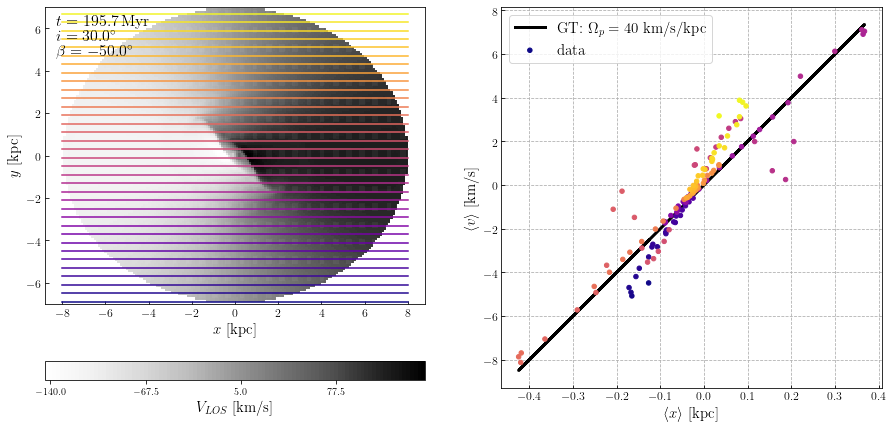

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

levels = np.linspace(np.nanmin(VR_array) * 100, np.nanmax(VR_array) * 100, 101)
cbarticks = np.linspace(np.nanmin(VR_array).round(1) * 100, np.nanmax(VR_array).round(1) * 100, 5)
norm = mc.BoundaryNorm(levels, 256)

ax1 = ax[0]
ax2 = ax[1]

sc = ax1.scatter(x_center_array, y_center_array, c=VR_array * 100, 
                 cmap='Greys', norm=norm, marker='s', s=3)
for index, y in enumerate(TW_method['y']):
    if index % 4 == 0:
        ax1.plot([-8, 8], [y, y], c=colors[index])
ax1.set_xlabel(r'$x$ [kpc]', fontsize=15)
ax1.set_ylabel(r'$y$ [kpc]', fontsize=15)
ax1.tick_params(labelsize=12, direction='in')
ax1.annotate(r'$t=%.1f\, \rm Myr$' % (t * to_Myr), xy=(0.03, 0.94),
             xycoords='axes fraction', fontsize=16, color='k')
ax1.annotate(r'$i=%.1f ^{\circ}$' % (np.rad2deg(i)), xy=(0.03, 0.89),
             xycoords='axes fraction', fontsize=16, color='k')
ax1.annotate(r'$\beta=%.1f ^{\circ}$' % (np.rad2deg(beta)), xy=(0.03, 0.84),
             xycoords='axes fraction', fontsize=16, color='k')

ax1.set_ylim(-7, 7)
cbar = plt.colorbar(sc, ax=ax1, orientation="horizontal", fraction=0.07, ticks=cbarticks)
cbar.set_label(label=r'$V_{LOS}$ [km/s]', size=15)


ax2.scatter(TW_method['x_weighted'], TW_method['VR_weighted'] * 100, s=20, c=colors, label=r'data', zorder=100)
ax2.plot(TW_method['x_weighted'], TW_method['x_weighted'] * 40 * np.sin(i),
         c='black', lw=3, label=r'GT: $\Omega_p = 40$ km/s/kpc')

# ax2.set_ylim(-2, 2)
# ax2.set_xlim(-0.05, 0.05)
ax2.tick_params(labelsize=12,direction='in')
ax2.set_xlabel(r' $\langle x \rangle$ [kpc]', fontsize=15)
ax2.set_ylabel(r' $\langle v \rangle$ [km/s]', fontsize=15)
ax2.legend(fontsize=15, loc='upper left')
ax2.grid(ls='dashed')
#plt.savefig(FIG_DIR / 'TW_method.png', bbox_inches='tight', dpi=300)

### slits contribution study

In [17]:
plasma = cm.get_cmap('plasma', len(TW_method))
colors_not_bar = plasma.colors

viridis = cm.get_cmap('viridis', len(TW_method))
colors_bar = viridis.colors

In [18]:
mask_not_bar = (TW_method['y'] < -4.5) | (TW_method['y'] > 4.5) 
mask_bar = (TW_method['y'] > -1.7) & (TW_method['y'] < 1.7) 

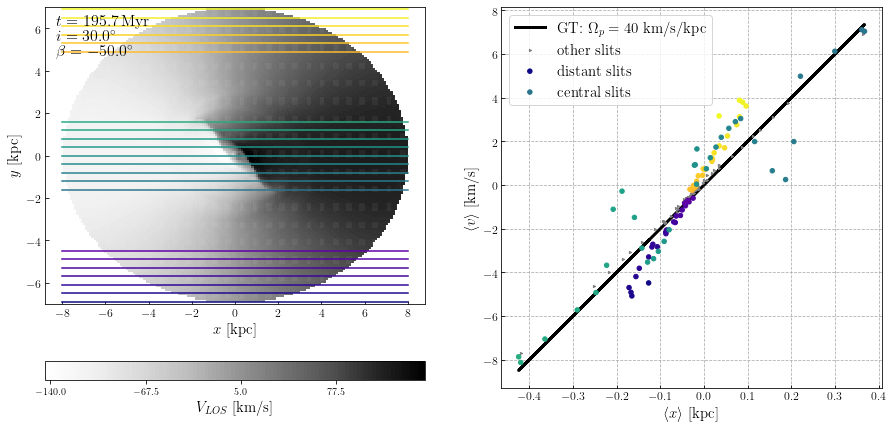

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

levels = np.linspace(np.nanmin(VR_array) * 100, np.nanmax(VR_array) * 100, 101)
cbarticks = np.linspace(np.nanmin(VR_array).round(1) * 100, np.nanmax(VR_array).round(1) * 100, 5)
norm = mc.BoundaryNorm(levels, 256)

ax1 = ax[0]
ax2 = ax[1]

sc = ax1.scatter(x_center_array, y_center_array, c=VR_array * 100, 
                 cmap='Greys', norm=norm, marker='s', s=3)
for index, y in enumerate(TW_method['y'][mask_not_bar]):
    if index % 4 == 0:
        ax1.plot([-8, 8], [y, y], c=colors_not_bar[mask_not_bar][index])
        
        
for index, y in enumerate(TW_method['y'][mask_bar]):
    if index % 4 == 0:
        ax1.plot([-8, 8], [y, y], c=colors_bar[mask_bar][index])

        
ax1.set_xlabel(r'$x$ [kpc]', fontsize=15)
ax1.set_ylabel(r'$y$ [kpc]', fontsize=15)
ax1.tick_params(labelsize=12, direction='in')
ax1.annotate(r'$t=%.1f\, \rm Myr$' % (t * to_Myr), xy=(0.03, 0.94),
             xycoords='axes fraction', fontsize=16, color='k')
ax1.annotate(r'$i=%.1f ^{\circ}$' % (np.rad2deg(i)), xy=(0.03, 0.89),
             xycoords='axes fraction', fontsize=16, color='k')
ax1.annotate(r'$\beta=%.1f ^{\circ}$' % (np.rad2deg(beta)), xy=(0.03, 0.84),
             xycoords='axes fraction', fontsize=16, color='k')

ax1.set_ylim(-7, 7)
cbar = plt.colorbar(sc, ax=ax1, orientation="horizontal", fraction=0.07, ticks=cbarticks)
cbar.set_label(label=r'$V_{LOS}$ [km/s]', size=15)


ax2.scatter(TW_method['x_weighted'], TW_method['VR_weighted'] * 100, s=5, c='gray', marker='>', label=r'other slits', zorder=10)
ax2.scatter(TW_method['x_weighted'][mask_not_bar], TW_method['VR_weighted'][mask_not_bar] * 100, s=20, c=colors_not_bar[mask_not_bar], label=r'distant slits', zorder=100)
ax2.scatter(TW_method['x_weighted'][mask_bar], TW_method['VR_weighted'][mask_bar] * 100, s=20, c=colors_bar[mask_bar], label=r'central slits', zorder=100)

ax2.plot(TW_method['x_weighted'], TW_method['x_weighted'] * 40 * np.sin(i),
        c='black', lw=3, label=r'GT: $\Omega_p = 40$ km/s/kpc')

# ax2.set_ylim(-2, 2)
# ax2.set_xlim(-0.05, 0.05)
ax2.tick_params(labelsize=12,direction='in')
ax2.set_xlabel(r' $\langle x \rangle$ [kpc]', fontsize=15)
ax2.set_ylabel(r' $\langle v \rangle$ [km/s]', fontsize=15)
ax2.legend(fontsize=15, loc='upper left')
ax2.grid(ls='dashed')
#plt.savefig(FIG_DIR / 'TW_method.png', bbox_inches='tight', dpi=300)